<Center><h3> Part 1 : Alternating Least Square(ALS)

### Import Section 

In [39]:
from time import time
import numpy as np
import random
import scipy 
from scipy import sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from functions import *
%matplotlib inline

### Explore Data 

In [40]:
def load_data(filename="u.data" , small_data=True):
    """
    This function returns :
        R : the matrix user-item containing the ratings
        mask : matrix is equal to 1 if a score existes and 0 otherwise
    """

    # Use this line to test on u.data (100K dataset)
    data = np.loadtxt(filename, dtype=int)
    
    # Use this line to test on ratings.csv (20M dataset) 
#     data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    

    
    
    R = sparse.csr_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),dtype=float)
    mask = sparse.csr_matrix((np.ones(data[:, 2].shape),(data[:, 0]-1, data[:, 1]-1)), dtype=bool )

    # take a small part of the whole data for testing 
    if small_data is True:
        R = (R[0:100, 0:100].copy())
        mask = (mask[0:100, 0:100].copy())
        
        
    return R.toarray(), mask.toarray()

In [4]:
R, mask = load_data(filename='u.data', small_data=True)

In [5]:
R

array([[ 5.,  3.,  4., ...,  4.,  3.,  5.],
       [ 4.,  0.,  0., ...,  0.,  0.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  3., ...,  5.,  0.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [6]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [ True, False,  True, ...,  True, False,  True],
       [False, False, False, ..., False, False, False]], dtype=bool)

The gradient of the objective function is given by : 


$$ \bigtriangledown f (P,Q) = \begin{pmatrix}
                    - Q^T\left[1_Ko(R - QP)\right] + \rho P \\ 
                    - \left[1_Ko (R - QP)\right] P^T + \rho Q
                    \end{pmatrix}
$$

** Initialize the matrix P and Q  **

In [7]:
rho = 0.2 # regularization parameter
C = 6 # projection space
U,S,Vt = scipy.sparse.linalg.svds(R, k=6) #SVD decomposition
Q0 = U
P0 = Vt

** Linear Search to find the minimum using the Armijo–Goldstein condition **

In [8]:
def search_gamma(func, P, c1, c2):
    n = 0
    gamma = c2 * (c1 ** n)
    P1 = P - gamma * func(P)[1]
    while func(P1)[0] >= func(P)[0] + np.vdot(func(P)[1], (P1-P)) + 1. / ( 2 * gamma) * (np.linalg.norm(P1-P) ** 2) :
        n += 1
        gamma = c2 * (c1 ** n)
        P1 = P - gamma * func(P)[1]
    return c2 * (c1 ** (n-1))


def grad_line_search(func, P0, epsilon): 
    P = P0
    max_iter = 0
    gamma = 0.5
    while (np.linalg.norm(func(P)[1]) > epsilon and max_iter < 300):
        c2 = gamma
        gamma = search_gamma(func ,P, 0.5, 0.5)
        P = P - gamma * func(P)[1]
        max_iter += 1
    return P, max_iter 

In [9]:
t = time()
P_star, n = grad_line_search(lambda P : objective(P, Q0, R, mask, rho), Vt, 1)

print("Running time : %0.2f s \nNumber of iterations : %d"%((time()-t),n))

Running time : 0.02 s 
Number of iterations : 8


** ALS Algorithm **

In [10]:
def ALS(P0, Q0, mask, rho, eps, max_iter):
    Q = Q0
    P = P0
    k = 0
    
    val, grad_P = objective_P(P0, Q0, R, mask, rho)
    _, grad_Q = objective_Q(P0, Q0, R, mask, rho)
    
    list_obj = []
    list_norm_P = []
    list_norm_Q = []

    list_obj.append(val)
    list_norm_P.append(np.linalg.norm(grad_P))
    list_norm_Q.append(np.linalg.norm(grad_Q))
    
    while (np.linalg.norm(grad_P) > eps or np.linalg.norm(grad_Q) > eps) and k < max_iter:
        
        # minimizing P and Q using a line search 
        P, _ = grad_line_search(lambda P : objective_P(P, Q, R, mask, rho), P, eps)
        Q, _ = grad_line_search(lambda Q : objective_Q(P, Q, R, mask, rho), Q, eps)
        
        val, grad_P = objective_P(P, Q, R, mask, rho)
        _, grad_Q = objective_Q(P, Q, R, mask, rho)
        k += 1
        
        list_obj.append(val)
        list_norm_P.append(np.linalg.norm(grad_P))
        list_norm_Q.append(np.linalg.norm(grad_Q))
        
        if k == 1 or k % 10 == 0:
            print("iteration = %d"%k)
            print("Norm of grad_P = %0.5f "%np.linalg.norm(grad_P))
            print("Norm of grad_Q = %0.5f "%np.linalg.norm(grad_Q))

    return P, Q, max_iter, list_obj, list_norm_P, list_norm_Q

**Test the ALS function **

In [11]:
rho = 0.2 # regularization parameter
C = 6 # projection space 
U,S,Vt = scipy.sparse.linalg.svds(R, k=6) #SVD decomposition
Q0 = U
P0 = Vt
eps = .1 # value of epsilon
max_iter = 300 # maximum of iterations

# call the Als function
P, Q, n, list_obj, list_norm_P, list_norm_Q = ALS(Vt, U, mask, rho, eps, max_iter)

iteration = 1
Norm of grad_P = 34.23989 
Norm of grad_Q = 44.61366 
iteration = 10
Norm of grad_P = 13.47818 
Norm of grad_Q = 3.65117 
iteration = 20
Norm of grad_P = 10.15628 
Norm of grad_Q = 0.68936 
iteration = 30
Norm of grad_P = 8.45526 
Norm of grad_Q = 0.37579 
iteration = 40
Norm of grad_P = 7.18822 
Norm of grad_Q = 0.09654 
iteration = 50
Norm of grad_P = 6.49649 
Norm of grad_Q = 0.55601 
iteration = 60
Norm of grad_P = 5.92887 
Norm of grad_Q = 0.46163 
iteration = 70
Norm of grad_P = 5.26699 
Norm of grad_Q = 0.20904 
iteration = 80
Norm of grad_P = 4.80220 
Norm of grad_Q = 0.09966 
iteration = 90
Norm of grad_P = 4.33362 
Norm of grad_Q = 0.09841 
iteration = 100
Norm of grad_P = 3.94026 
Norm of grad_Q = 0.09804 
iteration = 110
Norm of grad_P = 3.60102 
Norm of grad_Q = 0.09145 
iteration = 120
Norm of grad_P = 3.32327 
Norm of grad_Q = 0.15757 
iteration = 130
Norm of grad_P = 3.11901 
Norm of grad_Q = 0.28346 
iteration = 140
Norm of grad_P = 2.85846 
Norm of grad_

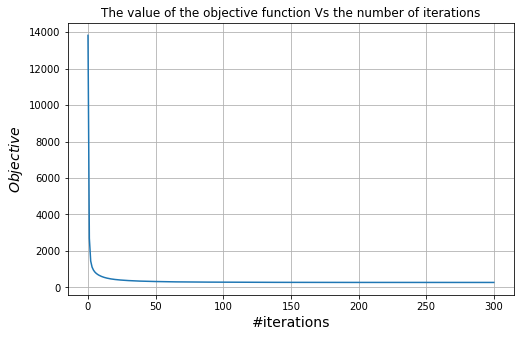

In [16]:
plt.figure(figsize=(8,5))

plt.plot(list_obj)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$Objective$", fontsize=14)
plt.title('The value of the objective function Vs the number of iterations')
plt.grid(True)

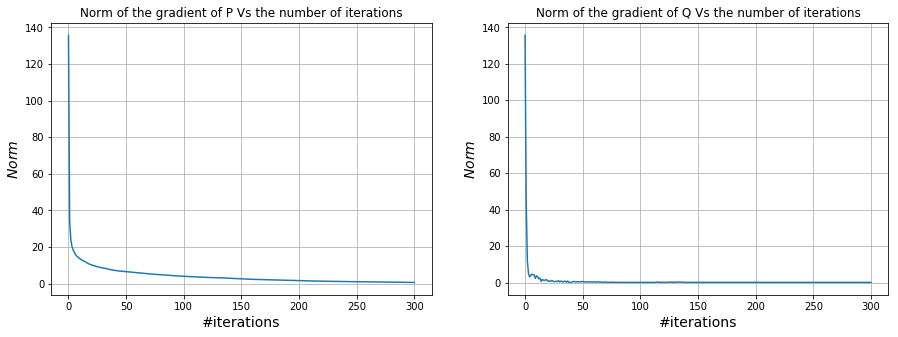

In [17]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(list_norm_P)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$Norm$", fontsize=14)
plt.title('Norm of the gradient of P Vs the number of iterations')
plt.grid(True)


plt.subplot(122)
plt.plot(list_norm_Q)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$Norm$", fontsize=14)
plt.title('Norm of the gradient of Q Vs the number of iterations')
plt.grid(True)
plt.show()

In [37]:
relative_error = np.linalg.norm(mask*(R - np.dot(Q, P))) / np.linalg.norm(R) * 100

print("Relative error : %f"%relative_error)
print("Total objective f(P,Q) = %0.5f "%(objective(P, Q, R, mask, rho)[0]))

Relative error : 10.801425
Total objective f(P,Q) = 269.09040 


** Recommandation ** 

In order to find the movie that we'll recommand to the user n° u, we have to consider the decomposition $ R = QP$.

In fact, by multiplying the $u^{th}$ row of Q by the matrix P, we obtain a vector r of size $ I$ x $ 1$ that contains all the estimated ratings of movies for this user u.   

Now, we only need to consider the highest score and take its index (which correspond to the recommanded movie), however we shoudn't forget that we have to avoid recommanding a movie that the user had already seen, that's why we need to multiply our vector r by the opposite of the mask. 


** What recommanding to the user n° 45 ?** 

In [32]:
u = 45
r = np.dot(Q[u,:], P)

r = r * (1 - mask[u,:])

movie_index = np.argmax(r)
print("We recommand to the user n° %s the movie n°  %d"%(u,movie_index))
print ("The rating of this movie is : %0.3f "%r[movie_index])

We recommand to the user n° 45 the movie n°  31
The rating of this movie is : 4.729 
